## Importing the relevant libraries

In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=b7976b36966dd06c8c6da09bd49358d3a71afa4ceaadf9a8dac568f9475f3a6b
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [ ]:
pip install tensorflow==2.12.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 9.1 MB/s eta 0:00:00
  Atte

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings, wget, gc
warnings.filterwarnings('ignore')
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from helper_prabowo_ml import clean_html, remove_, remove_digits, remove_digits, remove_special_characters, removeStopWords, remove_links, punct, email_address, lower, non_ascii

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Loading the dataset

In [ ]:
df = pd.read_csv("Symptom2Disease.csv")
df.drop('Unnamed: 0',axis=1,inplace=True)
df = df.sample(frac=0.5).reset_index(drop=True)
df.head()

,label,text
0,Pneumonia,"I have a really high fever, and I have problem..."
1,Migraine,"I have been suffering from acid reflux, indige..."
2,peptic ulcer disease,"A sour, acidic taste is all over my mouth. Bel..."
3,Typhoid,"The abdominal pain has been coming and going, ..."
4,urinary tract infection,"I need to relieve myself regularly, but I can'..."


In [ ]:
df.shape

(600, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   600 non-null    object
 1   text    600 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB


In [ ]:
df.describe()

,label,text
count,600,600
unique,24,588
top,Pneumonia,"I have a really high fever, and I have problem..."
freq,36,2


In [ ]:
df.isna().sum()

,0
label,0
text,0


In [ ]:
df.duplicated().sum()

12

In [ ]:
df = df.drop_duplicates()
df.shape

(588, 2)

## Exploratory Data Analysis (EDA)

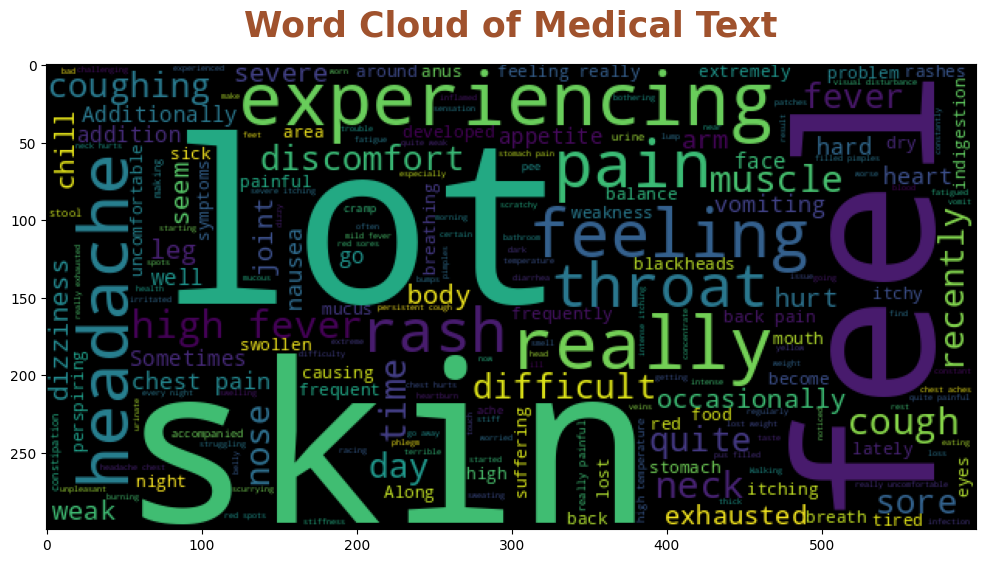

In [ ]:
plt.figure(figsize=(12,8))
wc = WordCloud(width=600,height=300,random_state=101).generate(' '.join(df.text))
plt.imshow(wc)
plt.title('Word Cloud of Medical Text',pad=20,fontsize=25,fontweight='bold',color='sienna');

In [ ]:
df['num_words'] = df.text.apply(len)
df.num_words.describe()

,num_words
count,588.000000
mean,170.425170
std,35.767366
min,60.000000
25%,147.000000
50%,167.000000
75%,191.250000
max,311.000000


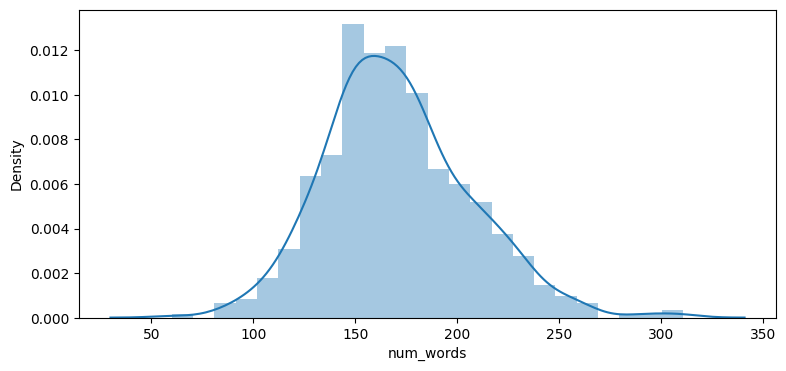

3184

In [ ]:
plt.figure(figsize=(9,4))
fig = sns.distplot(df['num_words'])
plt.show(fig)
plt.close('all')
del fig
gc.collect()

In [ ]:
max_len = 170

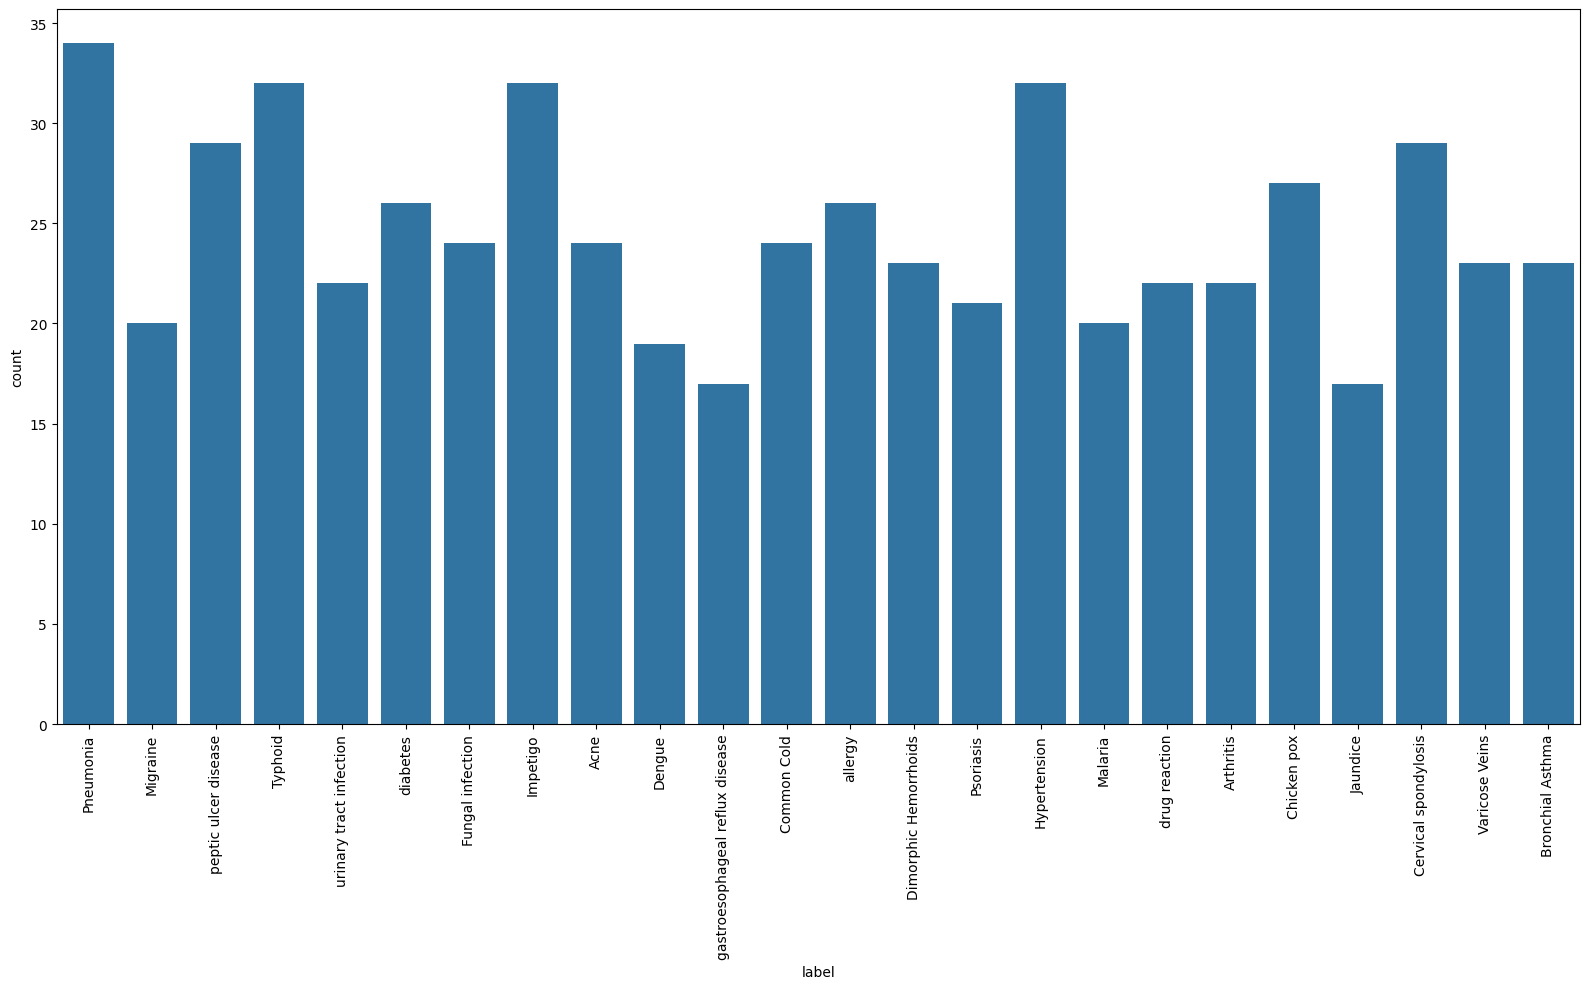

In [ ]:
plt.figure(figsize=(16,10))
fig = sns.countplot(x='label',data=df)
plt.xticks(rotation=90,)
plt.tight_layout()
plt.show(fig)
plt.close('all')
del fig
gc.collect();

The target label classes i.e. the case outcomes are relatively imbalanced so this imbalance in the target labels needs to be accounted during model creation.

## Text Preprocessing

In [ ]:
def clean_text(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=lower)
    return data

In [ ]:
preprocessed_df = clean_text(df,'text')
preprocessed_df.head()

,label,text,num_words
0,Pneumonia,really high fever problems breathing my heart ...,197
1,Migraine,suffering acid reflux indigestion frequent hea...,186
2,peptic ulcer disease,sour acidic taste mouth belching burping commo...,146
3,Typhoid,the abdominal pain coming going really unpleas...,171
4,urinary tract infection,need relieve regularly can t seem get bladder ...,172


## Encoding the target label classes

In [ ]:
encoder = LabelEncoder()
preprocessed_df['label'] = encoder.fit_transform(preprocessed_df['label'])

In [ ]:
labels_dict = dict()

for idx, label in enumerate(encoder.classes_):
    labels_dict[idx] = label

labels_dict

{0: 'Acne',
 1: 'Arthritis',
 2: 'Bronchial Asthma',
 3: 'Cervical spondylosis',
 4: 'Chicken pox',
 5: 'Common Cold',
 6: 'Dengue',
 7: 'Dimorphic Hemorrhoids',
 8: 'Fungal infection',
 9: 'Hypertension',
 10: 'Impetigo',
 11: 'Jaundice',
 12: 'Malaria',
 13: 'Migraine',
 14: 'Pneumonia',
 15: 'Psoriasis',
 16: 'Typhoid',
 17: 'Varicose Veins',
 18: 'allergy',
 19: 'diabetes',
 20: 'drug reaction',
 21: 'gastroesophageal reflux disease',
 22: 'peptic ulcer disease',
 23: 'urinary tract infection'}

## Splitting the preprocessed dataset into train and test sets

In [ ]:
train_df, test_df = train_test_split(preprocessed_df,test_size=0.3,stratify=preprocessed_df.label,shuffle=True,random_state=101)

## Downloading the Tokenizer and the pretrained BERT transformer model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('ajtamayoh/Symptoms_to_Diagnosis_SonatafyAI_BERT_v1')
bert_model = TFAutoModelForSequenceClassification.from_pretrained('ajtamayoh/Symptoms_to_Diagnosis_SonatafyAI_BERT_v1')

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


## Text Tokenization

In [ ]:
X_train = tokenizer(text=train_df.text.tolist(),
                   max_length=max_len,
                   padding='max_length',
                   truncation=True,
                   add_special_tokens=True,
                   return_attention_mask=True,
                   return_tensors='tf',
                   return_token_type_ids=False,
                   verbose=1)

X_test = tokenizer(text=test_df.text.tolist(),
                  max_length=max_len,
                  padding='max_length',
                  truncation=True,
                  add_special_tokens=True,
                  return_attention_mask=True,
                  return_tensors='tf',
                  return_token_type_ids=False,
                  verbose=1)

## Encoding the target labels

In [ ]:
y_train = to_categorical(train_df.label)
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_test = to_categorical(test_df.label)
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

## Defining the model architecture

In [ ]:
input_ids = Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
attention_mask = Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')

In [ ]:
embeddings = bert_model(input_ids,attention_mask=attention_mask)[0] # 0 --> final hidden state, 1 --> pooling output
output = Flatten()(embeddings)
output = Dense(units=128,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(units=64,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.1)(output)
output = Dense(units=32,activation='relu')(output)
output = Dense(units=24,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=output)
model.layers[2].trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 170)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 170)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109499158  ['input_ids[0][0]',              
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'attention_mask[0][0]']         
 fication)                      logits=(None, 22),                                                
                                 hidden_states=None                                           

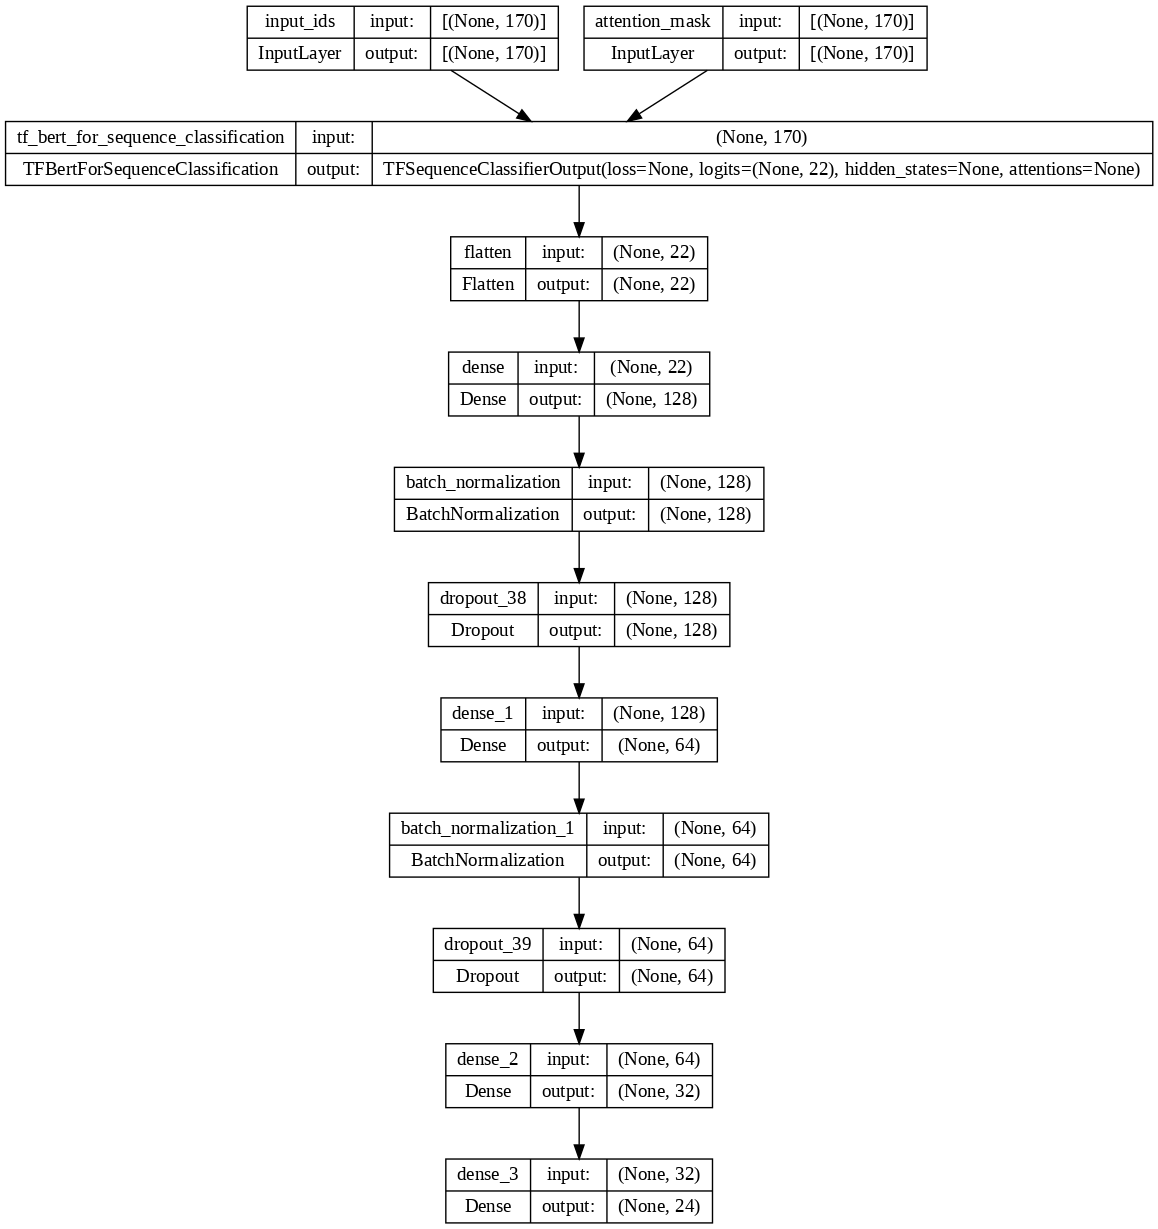

In [ ]:
plot_model(model,to_file='model.png',show_shapes=True,dpi=100)

## Compiling the model

In [ ]:
adam = Adam(learning_rate=5e-5, epsilon=2e-7, clipnorm=1.0)
model.compile(loss=CategoricalCrossentropy(from_logits=True),
              optimizer=adam,
              metrics=CategoricalAccuracy('balanced_accuracy'))

## Evaluating model performance on the test set using LSTM


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder

# Load the data (assuming you have a pandas DataFrame named 'df' with 'text' and 'label' columns)
# If your data loading is different, adjust this part accordingly.
df = pd.read_csv('Symptom2Disease.csv') # I have created a dummy file with the same data.

# Separate text and labels
X = df['text']
y = df['label']

# Preprocess the text data
tokenizer = Tokenizer(num_words=10000)  # Limit vocabulary size
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=200)  # Pad sequences to a maximum length

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=200))  # Embedding layer
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))  # LSTM layer
model.add(Dense(y_categorical.shape[1], activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print model summary to show the architecture
print(model.summary())

# Set up callbacks
es = EarlyStopping(monitor='val_categorical_accuracy', patience=10, verbose=1, mode='max')
mc = ModelCheckpoint(filepath='symptoms_disease_classifier_lstm.keras',  #Different name for the file.
                     monitor='val_categorical_accuracy', mode='max', save_best_only=True, verbose=1)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=50,  # Reduced number of epochs
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[es, mc])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Load the best model
best_model = load_model('symptoms_disease_classifier_lstm.keras')

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

print("Confusion Matrix:")
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(cm)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 24)                3096      
                                                                 
Total params: 1,414,680
Trainable params: 1,414,680
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 3.1447 - categorical_accuracy: 0.1927
Epoch 1: val_categorical_accuracy improved from -inf to 0.20417, saving model to symptoms_disease_classifier_lstm.keras
30/30 [==============================] - 25s 648ms/step - loss: 3.1447 - catego

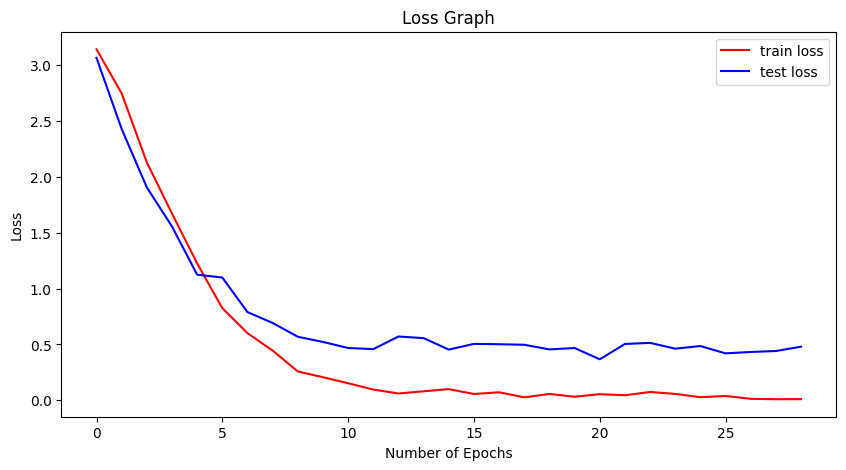

In [ ]:
import matplotlib.pyplot as plt

# Plot the training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], 'r', label='train loss')
plt.plot(history.history['val_loss'], 'b', label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

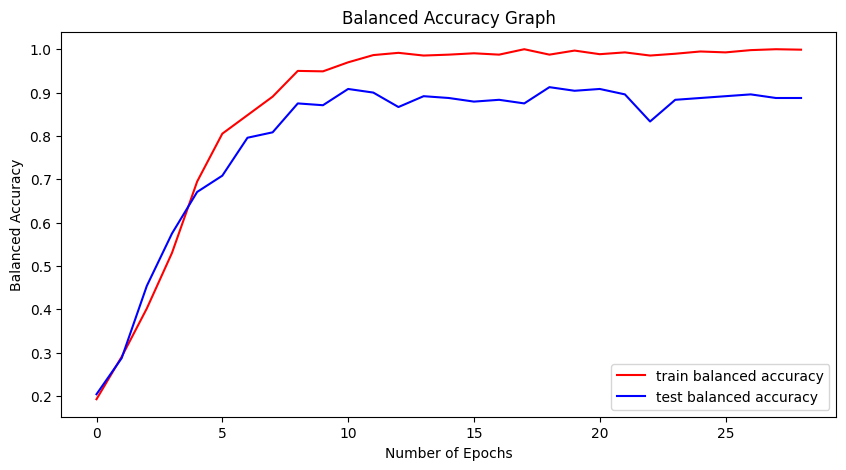

Maximum Training Balanced Accuracy: 100.00%
Maximum Testing Balanced Accuracy: 91.25%


In [ ]:
import matplotlib.pyplot as plt

# Plot the training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['categorical_accuracy'], 'r', label='train balanced accuracy')
plt.plot(history.history['val_categorical_accuracy'], 'b', label='test balanced accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Graph')
plt.legend()
plt.show()

# Print the maximum balanced accuracy
max_train_accuracy = max(history.history['categorical_accuracy']) * 100
max_test_accuracy = max(history.history['val_categorical_accuracy']) * 100
print(f"Maximum Training Balanced Accuracy: {max_train_accuracy:.2f}%")
print(f"Maximum Testing Balanced Accuracy: {max_test_accuracy:.2f}%")
